In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def load_and_split_data(file_path, is_dropping_diagnosis):
    patients = pd.read_csv(file_path, low_memory=False)

    if is_dropping_diagnosis:
        patients = patients.drop(columns=['diagnosis'])

    # categories = ['gender', 'admission_type', 'insurance', 'language', 'value', 'religion', 'marital_status', 'ethnicity',  'valueuom', 'flag', 'label', 'fluid', 'category']
    # one_hot_df = pd.get_dummies(patients[categories], drop_first=True)
    #
    # # Drop categorical columns
    # patients_numericals = patients.drop(columns=categories)
    #
    # # # Combine the numerical and one hot encoded dataframes
    # patients_enc = pd.concat([patients_numericals, one_hot_df], axis=1)
    #
    # # shuffle dataset
    # patients_enc = patients_enc.sample(frac=1, random_state=42).reset_index(drop=True)
    patients_enc = pd.get_dummies(patients)

    X = patients_enc.drop(columns='has_apnea')
    y = patients_enc['has_apnea']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    return X_train, X_test, y_train, y_test

# Random Forest Classifier

Accuracy: 99.9758%


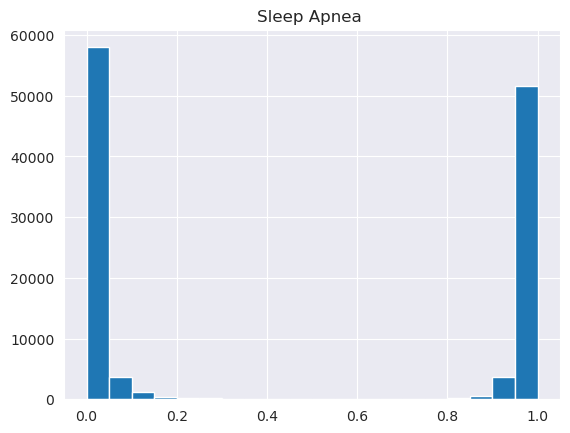

In [27]:
# Import the necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def run_model(X_train, X_test, y_train, y_test, title):
    clf = RandomForestClassifier()

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4%}")

    # Get probability predictions
    y_proba = clf.predict_proba(X_test)[:,1]

    # Plot the probabilities
    plt.hist(y_proba, bins=20)
    plt.title(title)
    plt.show()


# Run model with diagnosis column
X_train, X_test, y_train, y_test = load_and_split_data('patient_data_apnea_mix.csv', False)
run_model(X_train, X_test, y_train, y_test, "Sleep Apnea ")

# # Run model without diagnosis column
# X_train, X_test, y_train, y_test = load_and_split_data('patient_data_apnea_mix.csv', True)
# run_model(X_train, X_test, y_train, y_test)


# Find features that matter the most & graph them.

In [ ]:
# TODO: Get the feature importance's


# TODO: Graph feature importance's

# TODO: Consider dropping features that are not important
    # TODO: and retrain the model (see if accuracy improves)

# TODO: Consider clustering the data to see if there are any patterns